In [82]:
import os
import sys
import pathlib
import pickle as pkl

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import torch
import torchvision

from torch.utils.data import DataLoader, Subset

from datasets import deep_fashion
from arch import backbones, heads, models

from tqdm import tqdm

import utils.time

from time import time
from datetime import datetime

import pprint

In [83]:
training_name_str = "resnet50_ret"
now_datetime_str = "19-07-2023--11:56:13"

results_dir = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", training_name_str + "_" + now_datetime_str)

In [84]:
def load_train_data(filename):

    train_data = None
    with open(filename, 'rb') as file:
        train_data = pkl.load(file)

    return train_data

---

In [85]:
train_data_filename = "data.pkl"
train_data_full_filename = os.path.join(results_dir, train_data_filename)

train_data = load_train_data(train_data_full_filename)

In [86]:
pprint.pprint(train_data["settings"])

{'data_loading': {'batch_size': 256, 'num_workers': 16},
 'datasets': ['DeepFashion Consumer-to-shop Clothes Retrieval Benchmark'],
 'gpu_usage': [{'device_id': 0,
                'device_name': 'NVIDIA GeForce GTX 1080 Ti',
                'device_size': 11811160064,
                'device_size_fancy': ' 11.000 GiB'},
               {'device_id': 1,
                'device_name': 'NVIDIA GeForce GTX 1080 Ti',
                'device_size': 11811160064,
                'device_size_fancy': ' 11.000 GiB'},
               {'device_id': 2,
                'device_name': 'NVIDIA GeForce GTX 1080 Ti',
                'device_size': 11811160064,
                'device_size_fancy': ' 11.000 GiB'},
               {'device_id': 3,
                'device_name': 'NVIDIA GeForce GTX 1080 Ti',
                'device_size': 11811160064,
                'device_size_fancy': ' 11.000 GiB'},
               {'device_id': 4,
                'device_name': 'NVIDIA GeForce GTX 1080 Ti',
               

In [87]:
pprint.pprint(train_data["results"])

{'stage_1': {'mean_train_loss_list': [0.0006367069421513027],
             'mean_val_loss_list': [0.0005263473069301187],
             'num_epochs': 1,
             'train_epoch_time_list': [67.59493064880371],
             'val_epoch_time_list': [28.400195121765137]},
 'stage_2': {'mean_train_loss_list': [0.00030223352215082725],
             'mean_val_loss_list': [0.0004993254849631074],
             'num_epochs': 1,
             'train_epoch_time_list': [87.16612768173218],
             'val_epoch_time_list': [27.71829652786255]}}


---

In [88]:
mean_train_loss_list =\
    train_data["results"]["stage_1"]["mean_train_loss_list"] +\
    train_data["results"]["stage_2"]["mean_train_loss_list"]

mean_val_loss_list =\
    train_data["results"]["stage_1"]["mean_val_loss_list"] +\
    train_data["results"]["stage_2"]["mean_val_loss_list"]

stage_1_epochs = train_data["results"]["stage_1"]["num_epochs"]

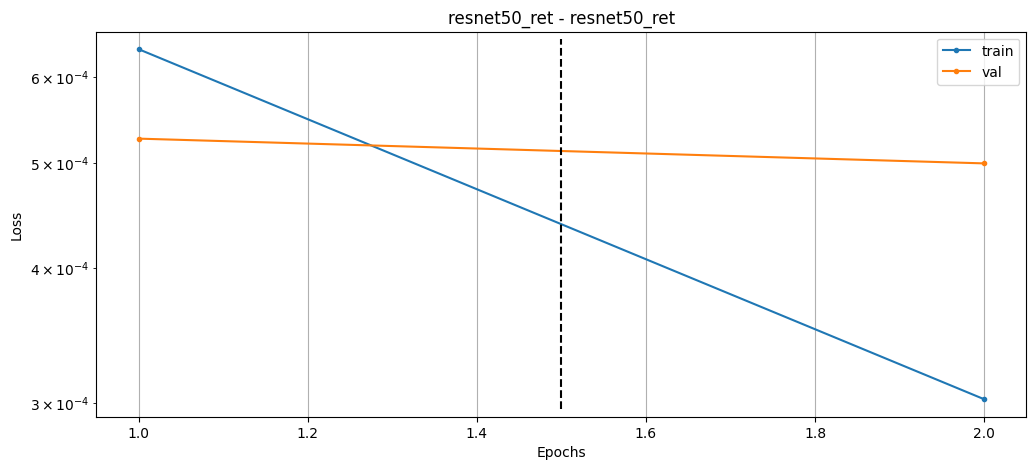

In [89]:
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label="train", marker=".")
plt.plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label="val", marker=".")
plt.yscale("log")

plt.axvline(stage_1_epochs + 0.5, ymin=0.02, ymax=0.98, color="black", linestyle="--")

plt.title("{:s} - {:s}".format(training_name_str, training_name_str))
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.grid()
plt.legend()

plt.show()

In [90]:
mean_train_loss_list =\
    train_data["settings"]["stage_1"]["learning_rate_list"] +\
    train_data["settings"]["stage_2"]["learning_rate_list"]

stage_1_epochs = train_data["results"]["stage_1"]["num_epochs"]

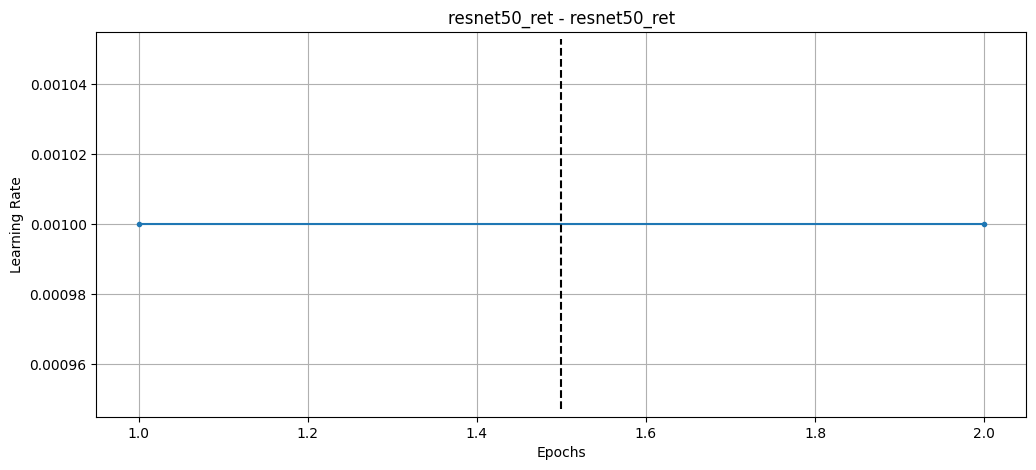

In [91]:
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, marker=".")
#plt.yscale("log")

plt.axvline(stage_1_epochs + 0.5, ymin=0.02, ymax=0.98, color="black", linestyle="--")

plt.title("{:s} - {:s}".format(training_name_str, training_name_str))
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")

plt.grid()

plt.show()

In [92]:
train_epoch_time_list =\
    train_data["results"]["stage_1"]["train_epoch_time_list"] +\
    train_data["results"]["stage_2"]["train_epoch_time_list"]

val_epoch_time_list =\
    train_data["results"]["stage_1"]["val_epoch_time_list"] +\
    train_data["results"]["stage_2"]["val_epoch_time_list"]

total_epoch_time_list = np.asarray(train_epoch_time_list) + np.asarray(val_epoch_time_list)
total_epoch_time_list_acc = np.cumsum(total_epoch_time_list)

stage_1_epochs = train_data["results"]["stage_1"]["num_epochs"]

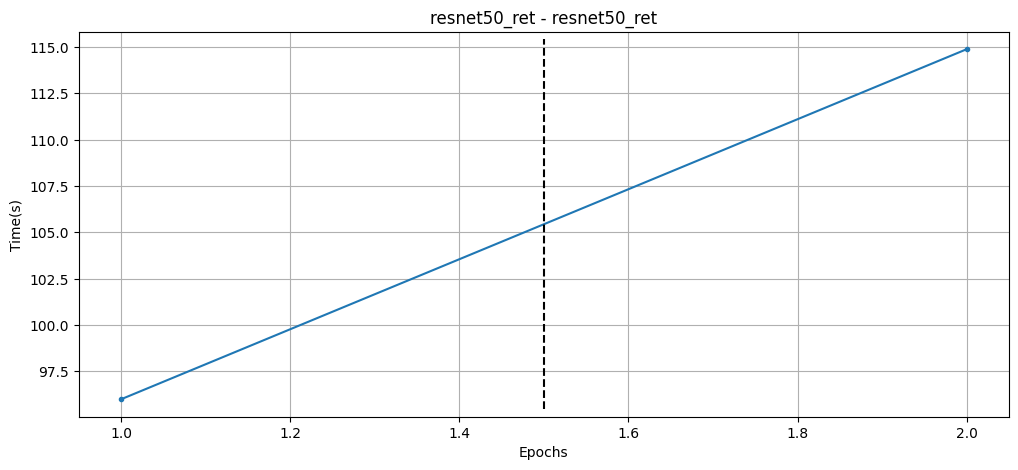

In [93]:
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(total_epoch_time_list) + 1), total_epoch_time_list, marker=".")
#plt.yscale("log")

plt.axvline(stage_1_epochs + 0.5, ymin=0.02, ymax=0.98, color="black", linestyle="--")

plt.title("{:s} - {:s}".format(training_name_str, training_name_str))
plt.xlabel("Epochs")
plt.ylabel("Time(s)")

plt.grid()

plt.show()

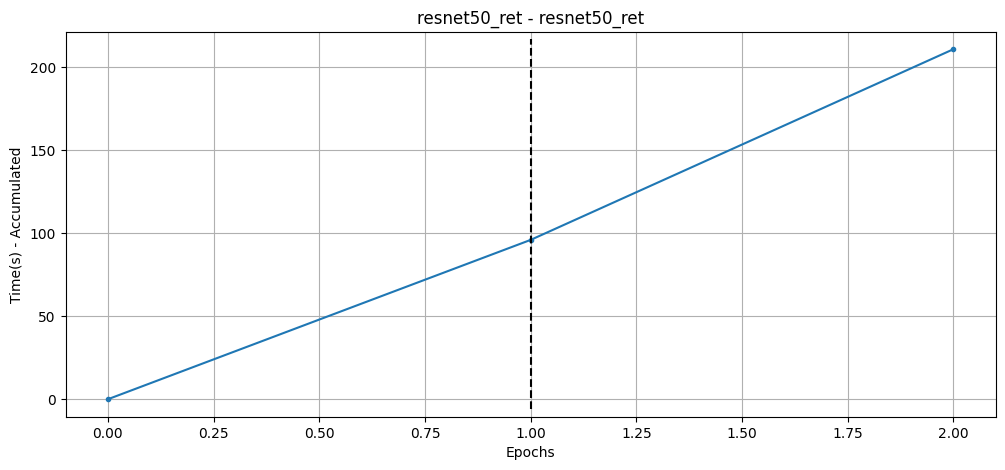

In [94]:
plt.figure(figsize=(12, 5))

plt.plot(range(len(total_epoch_time_list_acc) + 1), np.append(np.asarray([0]), total_epoch_time_list_acc), marker=".")
#plt.yscale("log")

plt.axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color="black", linestyle="--")

plt.title("{:s} - {:s}".format(training_name_str, training_name_str))
plt.xlabel("Epochs")
plt.ylabel("Time(s) - Accumulated")

plt.grid()

plt.show()

In [95]:
total_stage_1_time =\
    sum(train_data["results"]["stage_1"]["train_epoch_time_list"]) +\
    sum(train_data["results"]["stage_1"]["val_epoch_time_list"])

total_stage_2_time =\
    sum(train_data["results"]["stage_2"]["train_epoch_time_list"]) +\
    sum(train_data["results"]["stage_2"]["val_epoch_time_list"])

stage_1_epochs = train_data["results"]["stage_1"]["num_epochs"]
mean_stage_1_epoch_time = total_stage_1_time / stage_1_epochs

stage_2_epochs = train_data["results"]["stage_2"]["num_epochs"]
mean_stage_2_epoch_time = total_stage_2_time / stage_2_epochs

total_epoch_time = total_stage_1_time + total_stage_2_time

In [96]:
print("Total Stage 1 Time:      {:s}".format(utils.time.sprint_fancy_time_diff(total_stage_1_time)))
print("Total Stage 2 Time:      {:s}".format(utils.time.sprint_fancy_time_diff(total_stage_2_time)))
print("Mean Stage 1 Epoch Time: {:s}".format(utils.time.sprint_fancy_time_diff(mean_stage_1_epoch_time)))
print("Mean Stage 2 Epoch Time: {:s}".format(utils.time.sprint_fancy_time_diff(mean_stage_2_epoch_time)))
print("Total Epoch Time:        {:s}".format(utils.time.sprint_fancy_time_diff(total_epoch_time)))

Total Stage 1 Time:      0:01:35.995
Total Stage 2 Time:      0:01:54.884
Mean Stage 1 Epoch Time: 0:01:35.995
Mean Stage 2 Epoch Time: 0:01:54.884
Total Epoch Time:        0:03:30.879
